# To Do List

Change to use Bloomberg Data.
Note that there is no Close due to Open == Close

Select better features to train on.
We can create our own features. (Like Distance from MA)

# Initialisation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

import ta

In [4]:
#IMPORTANT
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load the raw data
df_EURUSD = pd.read_csv('./FX Data/EURUSD1.csv', names=['Date','Time','Open','High','Low','Close','Volume'])

In [6]:
df_EURUSD['Timestamp'] = 0

In [7]:
for i in range(len(df_EURUSD)):
    df_EURUSD.at[i,'Timestamp']=i

In [8]:
# Add in technical indicators
df_ta=ta.add_all_ta_features(df_EURUSD, 'Open','High','Low','Close','Volume',fillna=True)

In [9]:
df_EURUSD.shape

(65000, 69)

In [10]:
df_EURUSD.head()

,Date,Time,Open,High,Low,Close,Volume,Timestamp,volume_adi,volume_obv,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2019.08.15,15:22,1.11542,1.11547,1.11542,1.11544,20,0,-3.738490,20,...,99.757407,40.000000,40.000000,-60.000000,0.0,1.11544,0.0,1.118336,0.000000,0.000000
1,2019.08.15,15:23,1.11544,1.11567,1.11544,1.11564,54,1,35.913043,74,...,99.523674,88.000000,64.000000,-12.000000,0.0,1.11564,0.0,0.017930,0.017929,0.017930
2,2019.08.15,15:24,1.11564,1.11573,1.11563,1.11573,43,2,82.913043,117,...,99.527425,100.000000,76.000000,-0.000000,0.0,1.11573,0.0,0.008067,0.008067,0.025999
3,2019.08.15,15:25,1.11573,1.11579,1.11570,1.11579,41,3,84.000000,158,...,99.530752,100.000000,96.000000,-0.000000,0.0,1.11579,0.0,0.005378,0.005378,0.031378
4,2019.08.15,15:26,1.11579,1.11579,1.11569,1.11572,34,4,27.400000,124,...,98.991185,81.081081,93.693694,-18.918919,0.0,1.11572,0.0,-0.006274,-0.006274,0.025102


# Let's Plot Some Features! (detour)

### Bollinger Bands

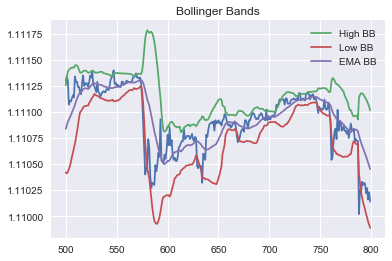

In [11]:
plt.plot(df_EURUSD[500:800].Close)
plt.plot(df_EURUSD[500:800].volatility_bbh, label='High BB')
plt.plot(df_EURUSD[500:800].volatility_bbl, label='Low BB')
plt.plot(df_EURUSD[500:800].volatility_bbm, label='EMA BB')
plt.title('Bollinger Bands')
plt.legend()
plt.show()

# Classifiers


Stack RBF SVM, Decision Tree, and KNN together with with Logistic Regression as a meta-classifier.

#### Imports and Functions

In [38]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [13]:
def prepare_feature_matrix(start_ind, end_ind):
    df_temp=df_EURUSD[start_ind:end_ind]
    df_temp['delta']=0
    for i in range(start_ind, start_ind+len(df_temp)-1):
        if df_temp.loc[i+1,'Close'] > df_temp.loc[i,'Close']:
            df_temp.loc[i,'delta'] = 1
    X_temp = df_temp.drop(axis=1, labels=['Close','Timestamp','Date','Time','Open','High','Low','Volume','delta']).values
    y_temp=df_temp['delta'].to_frame().values
    return [X_temp,y_temp]

In [77]:
training_1 = prepare_feature_matrix(500,4500)

In [78]:
pred_1 = prepare_feature_matrix(5000,5500)

In [16]:
ta_list=df_EURUSD.columns.to_list()

for name in ['Close','Timestamp','Date','Time','Open','High','Low','Volume']:
    ta_list.remove(name)

## All them models
#### RBF SVM

In [36]:
svm_model=svm.SVC()
svm_model.fit(training_1[0],training_1[1])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [37]:
svm_y_pred=svm_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],svm_y_pred))

0.62


#### Decision Tree

In [19]:
dt_model=DecisionTreeClassifier()
dt_model.fit(training_1[0],training_1[1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
dt_y_pred=dt_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],dt_y_pred))

0.536


#### KNN

In [33]:
knn_model=KNeighborsClassifier(n_neighbors=10)
knn_model.fit(training_1[0],training_1[1])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [34]:
knn_y_pred=knn_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],knn_y_pred))

0.62


#### Logistic Regression (Stacking)

In [66]:
lr_stack = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial')

In [63]:
svm_model.predict([training_1[0][0]])

array([1], dtype=int64)

In [89]:
def prepare_master_feature(start_ind, end_ind):
    master_feature=[]
    for ele in prepare_feature_matrix(start_ind,end_ind)[0]:
        temp_list=[]
        feature_matrix=ele.reshape(1,-1)
        temp_list.append(svm_model.predict(feature_matrix))
        temp_list.append(dt_model.predict(feature_matrix))
        temp_list.append(knn_model.predict(feature_matrix))
        master_feature.append(temp_list)
    return np.asarray(master_feature)

In [64]:
master_feature=[]
for i in range(len(training_1[1])):
    temp_list=[]
    temp_list.append(svm_model.predict([training_1[0][i]]))
    temp_list.append(dt_model.predict([training_1[0][i]]))
    temp_list.append(knn_model.predict([training_1[0][i]]))
    master_feature.append(temp_list)

In [91]:
mf1=prepare_master_feature(5000,5500)

In [94]:
mf1.shape

(500, 3, 1)

In [88]:
prepare_feature_matrix(5000,5500)[0][1].reshape(1,-1)

array([[ 7.33333333e+01,  1.21700000e+04,  1.84832079e-01,
        -3.69000000e-03,  6.00000000e-04, -1.96747457e-03,
         1.35149746e-03,  9.97828538e+02,  3.93458805e-05,
         1.10996088e+00,  1.10982312e+00,  1.10989200e+00,
         0.00000000e+00,  0.00000000e+00,  1.10987067e+00,
         1.10987067e+00,  1.10982967e+00,  0.00000000e+00,
         0.00000000e+00,  1.10985000e+00,  1.10996000e+00,
         0.00000000e+00,  0.00000000e+00, -1.60098081e-05,
        -2.02363157e-05,  4.22650761e-06,  1.10988419e+00,
         1.10990020e+00,  2.75077049e+01,  1.69650680e+01,
         2.75495342e+01,  8.86792453e-01,  1.03773585e+00,
        -1.50943396e-01, -2.67042540e-04,  2.54349363e+01,
        -3.83141762e+00, -3.20000000e-05, -6.54370003e-02,
        -5.84699883e-02, -6.96701202e-03,  1.10988750e+00,
         1.10993000e+00,  1.10992500e+00,  1.10995000e+00,
         4.00000000e+00,  6.00000000e+01, -5.60000000e+01,
         5.19365842e+01,  7.04169751e+01, -7.05932164e+0

In [71]:
master_feature=np.asarray(master_feature)

In [73]:
master_feature.shape

(4000, 3, 1)

In [74]:
master_feature=master_feature.reshape((4000,3))

In [76]:
master_feature

array([[1, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int64)

In [75]:
lr_stack.fit(master_feature,training_1[1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
lr_pred=lr_stack.predict(mf1.reshape(500,3))

In [96]:
print(metrics.accuracy_score(pred_1[1],lr_pred))

0.62


#### NuSVC

In [31]:
NuSVC_model=svm.NuSVC(gamma='auto')
NuSVC_model.fit(training_1[0],training_1[1])

NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [32]:
NuSVC_y_pred=NuSVC_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],NuSVC_y_pred))

0.62


#### Random Forest Classifier

In [58]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [59]:
rfc_model=RandomForestClassifier(n_jobs=2)

##### We do a search to find best parameters.

In [62]:
rfc_random= RandomizedSearchCV(estimator=rfc_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [66]:
rfc_random.fit(training_1[0],training_1[1])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10, n_jobs=2,
                                                    oob_s

In [67]:
rfc_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [56]:
rfc_y_pred=rfc_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],rfc_y_pred))

0.582


In [70]:
rfc_tuned=RandomForestClassifier(n_estimators=200, 
                                 min_samples_split=5, 
                                 min_samples_leaf=4, 
                                max_features='auto',
                                max_depth=10,
                                bootstrap=True)

In [71]:
rfc_tuned.fit(training_1[0],training_1[1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [72]:
rfc_tuned_y_pred=rfc_tuned.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],rfc_tuned_y_pred))

0.6


##### Can even do GridSearchCV to further improve results.

#### XGB

In [47]:
xgb_model=XGBClassifier()
xgb_model.fit(training_1[0],training_1[1])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
xgb_y_pred=xgb_model.predict(pred_1[0])
print(metrics.accuracy_score(pred_1[1],xgb_y_pred))

0.576


In [51]:
flist=list(zip(ta_list,xgb_model.feature_importances_))

In [52]:
flist[53]

('momentum_stoch_signal', 0.033068422)

In [73]:
flist

[('volume_adi', 0.018726664),
 ('volume_obv', 0.024882253),
 ('volume_cmf', 0.013570454),
 ('volume_fi', 0.017151598),
 ('volume_em', 0.017188232),
 ('volume_sma_em', 0.020002875),
 ('volume_vpt', 0.023072047),
 ('volume_nvi', 0.025042659),
 ('volatility_atr', 0.025332808),
 ('volatility_bbh', 0.012741786),
 ('volatility_bbl', 0.0108969305),
 ('volatility_bbm', 0.02439562),
 ('volatility_bbhi', 0.0),
 ('volatility_bbli', 0.0),
 ('volatility_kcc', 0.01432274),
 ('volatility_kch', 0.0),
 ('volatility_kcl', 0.022804623),
 ('volatility_kchi', 0.0),
 ('volatility_kcli', 0.0),
 ('volatility_dcl', 0.019303326),
 ('volatility_dch', 0.026901037),
 ('volatility_dchi', 0.0),
 ('volatility_dcli', 0.0),
 ('trend_macd', 0.016886238),
 ('trend_macd_signal', 0.019235482),
 ('trend_macd_diff', 0.015208815),
 ('trend_ema_fast', 0.02118907),
 ('trend_ema_slow', 0.022253638),
 ('trend_adx', 0.016276736),
 ('trend_adx_pos', 0.016418941),
 ('trend_adx_neg', 0.018656578),
 ('trend_vortex_ind_pos', 0.01789304

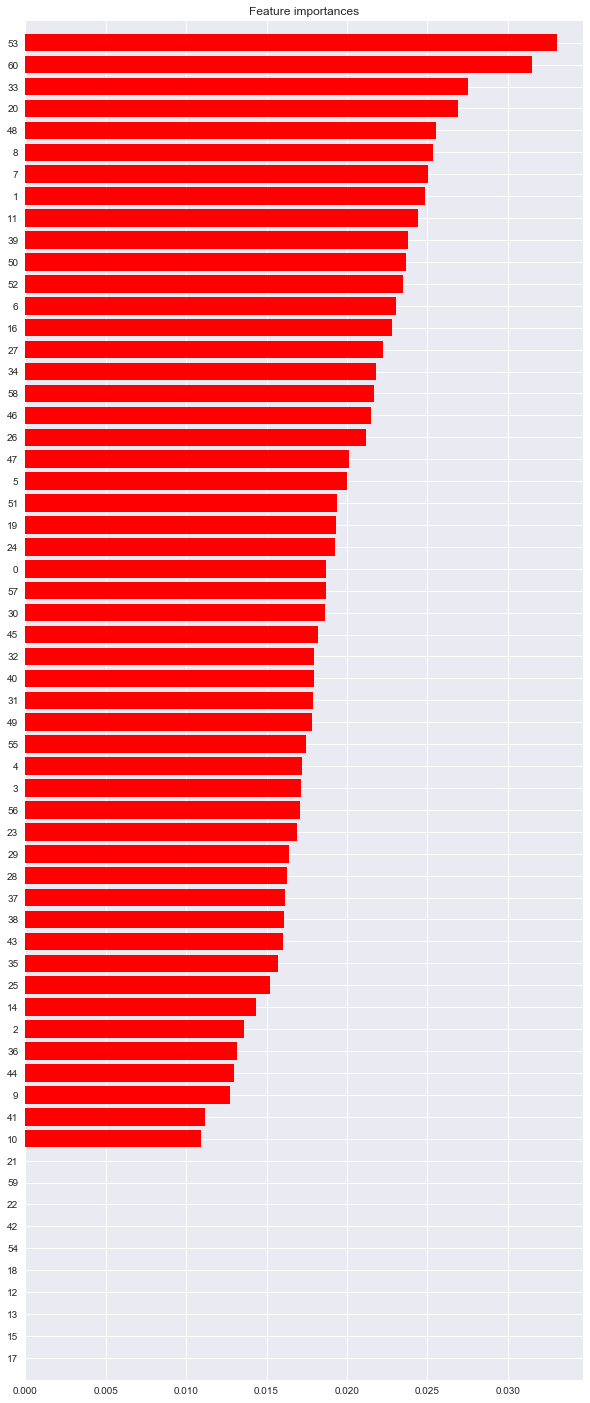

In [49]:
importances=xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (10,25))
plt.title("Feature importances")
plt.barh(range(training_1[0].shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(training_1[0].shape[1]), indices)
plt.ylim([-1, training_1[0].shape[1]])
plt.show()

# Random Stuff